# Capstone 2 Project - Sentiment Analysis from Twitter #IPL   


<img src="https://github.com/sunilayyaps/datascience/blob/master/capstone-project2/ipl/images/social_sentiment_logo.png?raw=true">


In [1]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing
import csv
import plotly
# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from textblob import TextBlob
from wordcloud import WordCloud
from credentials import *    # This will allow us to use the keys as variables
from textblob import TextBlob
import re
from wordcloud import STOPWORDS
from plotly import graph_objs
from plotly.offline import init_notebook_mode, iplot
from plotly import __version__
init_notebook_mode()
print("plotly version:",__version__)
from collections import Counter


import os
import nltk
import arrow
from locale import atof
from dateutil import parser
from datetime import datetime
#nltk.download('stopwords')

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE


import warnings
import requests
import zipfile
import io
import json
import unicodedata

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import locale
import arrow
import xml.etree.ElementTree as ET

from locale import atof
from dateutil import parser
from datetime import datetime

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


plotly version: 2.4.0


/Users/sunilayyappan/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
# Access:
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True)
#####United Airlines
# Open/Create a file to append data
csvFile = open('sscricket.csv', 'a')
#Use csv Writer
csvWriter = csv.writer(csvFile)
for tweet in tweepy.Cursor(api.search,q="#ipl",count=1000,
                           lang="en",
                           since="2018-02-18").items():
    csvWriter.writerow([tweet.id,tweet.created_at, tweet.text,tweet.source,tweet.favorite_count,tweet.retweet_count])

In [3]:
col_Names = ["id","created", "tweet","source","fav_count","retweet"]
data_tweet = pd.read_csv('sscricket.csv', names=col_Names)


# We display the first 10 elements of the dataframe:
display(data_tweet.head(5))

,id,created,tweet,source,fav_count,retweet
0,971114387510628352,2018-03-06 20:04:47,Call today to find out what an #IPL treatment ...,Crystal Clear DM SPC,0,0
1,971111229900062721,2018-03-06 19:52:14,Not thinking about #IPL just yet: Saha \nhttps...,Twitter Web Client,0,0
2,971111185180479488,2018-03-06 19:52:03,One of our Marvellous March offers. This offer...,Sprout Social,0,0
3,971110930376359936,2018-03-06 19:51:02,RT @CricFit: Do You Know? #IPL #T20 #Cricket h...,Twitter for Android,0,5
4,971109803132043264,2018-03-06 19:46:34,RT @IPL2018AUCTION: #IPL Captains with best wi...,Twitter for iPhone,0,1


In [4]:
data_tweet.shape

(8554, 6)

### Utilities
Add helper functions here.


In [5]:
# Stub for helpers
# convert utc to est
def convertUTCtoFull(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('dddd, MMM D, YYYY h:mm A')

# convert to month
def convertUTCtoMonth(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('MM')

# convert to day
def convertUTCtoDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('D')

# convert to month/day
def convertUTCtoMonthDay(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('YYYY-MM-DD')

# convert to day of week
def convertUTCtoDayOfWeek(date):
    utc = arrow.get(date)
    return utc.to('US/Eastern').format('d')

# convert to time
def convertUTCtoHourOfDay(date):
    utc = arrow.get(date)
    return int(utc.to('US/Eastern').format('HH'))

# convert to week of year
def convertUTCtoWeekNumber(date):
    return int(date.strftime('%U'))

# Strip HTML
def stripHTML(html):
    tree = ET.fromstring(html)
    return ET.tostring(tree, encoding='utf8', method='text')

# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

### Data Processing

In [6]:
# We create time series for data:
data_tweet['len']  = data_tweet['tweet'].apply(len)
tlen = pd.Series(data=data_tweet['len'].values)
tfav = pd.Series(data=data_tweet['fav_count'].values)
tret = pd.Series(data=data_tweet['retweet'].values)

In [7]:
# We extract the tweet with more FAVs and more RTs:

fav_max = np.max(data_tweet['fav_count'])
rt_max  = np.max(data_tweet['retweet'])

fav = data_tweet[data_tweet.fav_count == fav_max].index[0]
rt  = data_tweet[data_tweet.retweet == rt_max].index[0]

# Max FAVs:
print("The tweet with more likes is: \n{}".format(data_tweet['tweet'][fav]))
print("Number of likes: {}".format(fav_max))
print("{} characters.\n".format(data_tweet['len'][fav]))

# Max RTs:
print("The tweet with more retweets is: \n{}".format(data_tweet['tweet'][rt]))
print("Number of retweets: {}".format(rt_max))
print("{} characters.\n".format(data_tweet['len'][rt]))

The tweet with more likes is: 
Looking forward to the new #IPL season under our new skipper @ashwinravi99.. Congratulations and Good luck Ash.. ✌️… https://t.co/a0mcaPWBFG
Number of likes: 3869
140 characters.

The tweet with more retweets is: 
RT @IPLCricket: Most Fan Based Team In #IPL

Favorite : #MI

Retweet : #CSK

Reply : #RCB

#IPLAuction #IPL2018
Number of retweets: 4117
111 characters.



In [8]:
data_tweet['human_date'] = data_tweet['created'].apply(convertUTCtoFull)
data_tweet['month/day'] = data_tweet['created'].apply(convertUTCtoMonthDay)
data_tweet['month'] = data_tweet['created'].apply(convertUTCtoMonth)
data_tweet['day'] = data_tweet['created'].apply(convertUTCtoDay)
data_tweet['day of week'] = data_tweet['created'].apply(convertUTCtoDayOfWeek)
data_tweet['hour'] = data_tweet['created'].apply(convertUTCtoHourOfDay)
data_tweet['text encoded'] = data_tweet['tweet'].apply(encodeText)
data_tweet['len']  = data_tweet['tweet'].apply(len)
data_tweet.set_index('created', inplace=True)

In [9]:
display(data_tweet.head(5))

,id,tweet,source,fav_count,retweet,len,human_date,month/day,month,day,day of week,hour,text encoded
created,,,,,,,,,,,,,
2018-03-06 20:04:47,971114387510628352,Call today to find out what an #IPL treatment ...,Crystal Clear DM SPC,0,0,131,"Tuesday, Mar 6, 2018 3:04 PM",2018-03-06,03,6,2,15,b'Call today to find out what an #IPL treatmen...
2018-03-06 19:52:14,971111229900062721,Not thinking about #IPL just yet: Saha \nhttps...,Twitter Web Client,0,0,79,"Tuesday, Mar 6, 2018 2:52 PM",2018-03-06,03,6,2,14,b'Not thinking about #IPL just yet: Saha \nhtt...
2018-03-06 19:52:03,971111185180479488,One of our Marvellous March offers. This offer...,Sprout Social,0,0,140,"Tuesday, Mar 6, 2018 2:52 PM",2018-03-06,03,6,2,14,b'One of our Marvellous March offers. This off...
2018-03-06 19:51:02,971110930376359936,RT @CricFit: Do You Know? #IPL #T20 #Cricket h...,Twitter for Android,0,5,68,"Tuesday, Mar 6, 2018 2:51 PM",2018-03-06,03,6,2,14,b'RT @CricFit: Do You Know? #IPL #T20 #Cricket...
2018-03-06 19:46:34,971109803132043264,RT @IPL2018AUCTION: #IPL Captains with best wi...,Twitter for iPhone,0,1,140,"Tuesday, Mar 6, 2018 2:46 PM",2018-03-06,03,6,2,14,b'RT @IPL2018AUCTION: #IPL Captains with best ...


In [10]:
# We extract the mean of lenghts:
mean = np.mean(data_tweet['len'])
print("The Average length of all tweets: {:2f}".format(mean))

The Average length of all tweets: 127.074585


## Source

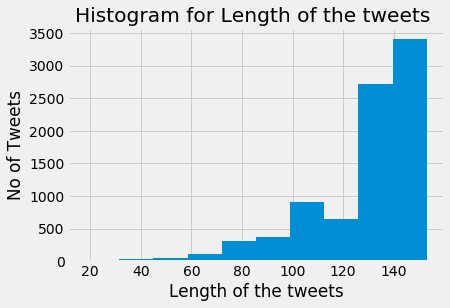

In [11]:
#plotting a histogram on the length of the tweets.
tlen.hist()
plt.ylabel('No of Tweets')
plt.xlabel('Length of the tweets')
plt.title(r'Histogram for Length of the tweets ')
plt.rcParams['figure.figsize'] = (8, 8)


Text(0.5,1,'Visualization on Number of Likes & Tweets ')

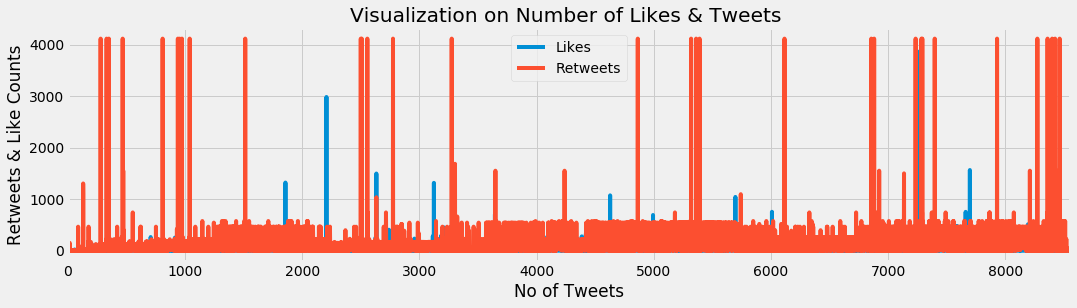

In [12]:
# Likes vs retweets visualization:
tfav.plot(figsize=(16,4), label="Likes", legend=True)
tret.plot(figsize=(16,4), label="Retweets", legend=True);
plt.ylabel('Retweets & Like Counts')
plt.xlabel('No of Tweets')
plt.title(r'Visualization on Number of Likes & Tweets ')

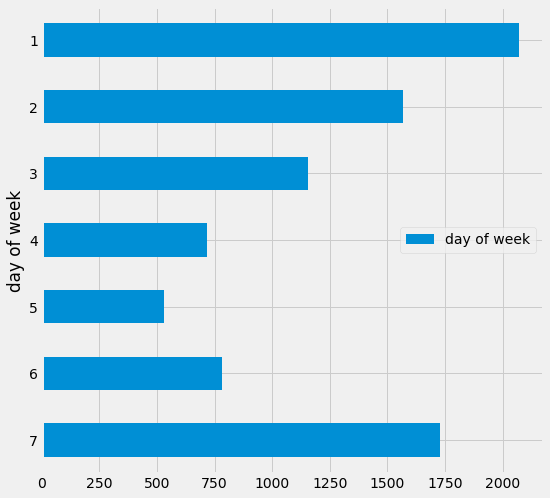

In [13]:
tweetsPerDayOfWeek = data_tweet[['day of week']].groupby(data_tweet['day of week']).count()
tweetsPerDayOfWeek.iloc[::-1].plot(kind='barh')

In [14]:
df_source = data_tweet.groupby(['source']).size().reset_index(name='counts')

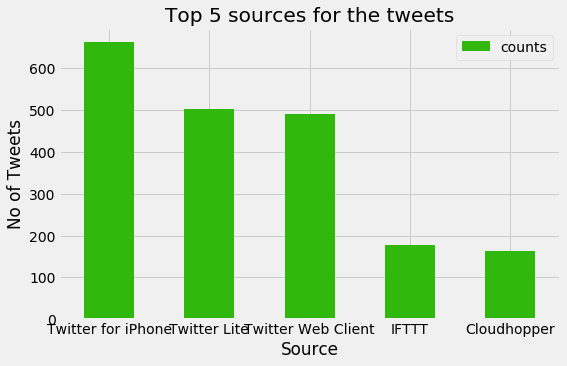

In [15]:
result = df_source.sort_values(by='counts')[-6:-1]
result.sort_values(by='counts',ascending=[False]).plot(x='source',kind='bar',figsize=(8,5),color=['#31B80D','#E8A70C','#280CE8','#0DFFBF','#690000'])
plt.ylabel('No of Tweets')
plt.xlabel('Source')
plt.title('Top 5 sources for the tweets')
plt.xticks(rotation=0)
plt.show()
plt.rcParams['figure.figsize'] = (12, 8)


## Sentiment Analysis

In [16]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [17]:
def count_by_lambda(expression, word_array):
            return len(list(filter(expression, word_array)))
    
def count_occurences(character, word_array):
            counter = 0
            for j, word in enumerate(word_array):
                for char in word:
                    if char == character:
                        counter += 1
            return counter

In [18]:
data_tweet['uppercase_no'] = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),data_tweet['tweet']))
data_tweet['hashtag_no'] = list(map(lambda txt: count_occurences('#', txt),data_tweet['tweet']))
data_tweet['exclamation_no'] = list(map(lambda txt: count_occurences('!', txt),data_tweet['tweet']))
data_tweet['question_no'] = list(map(lambda txt: count_occurences('?', txt),data_tweet['tweet']))
data_tweet['mention_no'] = list(map(lambda txt: count_occurences('@', txt),data_tweet['tweet']))

In [19]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [20]:
# We create a column with the result of the analysis:
data_tweet['SA'] = np.array([ analize_sentiment(tweet) for tweet in data_tweet['tweet'] ])

# We display the updated dataframe with the new column:
display(data_tweet.head(5))

,id,tweet,source,fav_count,retweet,len,human_date,month/day,month,day,day of week,hour,text encoded,uppercase_no,hashtag_no,exclamation_no,question_no,mention_no,SA
created,,,,,,,,,,,,,,,,,,,
2018-03-06 20:04:47,971114387510628352,Call today to find out what an #IPL treatment ...,Crystal Clear DM SPC,0,0,131,"Tuesday, Mar 6, 2018 3:04 PM",2018-03-06,03,6,2,15,b'Call today to find out what an #IPL treatmen...,53,4,0,0,0,0
2018-03-06 19:52:14,971111229900062721,Not thinking about #IPL just yet: Saha \nhttps...,Twitter Web Client,0,0,79,"Tuesday, Mar 6, 2018 2:52 PM",2018-03-06,03,6,2,14,b'Not thinking about #IPL just yet: Saha \nhtt...,31,2,0,0,0,0
2018-03-06 19:52:03,971111185180479488,One of our Marvellous March offers. This offer...,Sprout Social,0,0,140,"Tuesday, Mar 6, 2018 2:52 PM",2018-03-06,03,6,2,14,b'One of our Marvellous March offers. This off...,40,0,0,0,0,1
2018-03-06 19:51:02,971110930376359936,RT @CricFit: Do You Know? #IPL #T20 #Cricket h...,Twitter for Android,0,5,68,"Tuesday, Mar 6, 2018 2:51 PM",2018-03-06,03,6,2,14,b'RT @CricFit: Do You Know? #IPL #T20 #Cricket...,38,3,0,1,1,0
2018-03-06 19:46:34,971109803132043264,RT @IPL2018AUCTION: #IPL Captains with best wi...,Twitter for iPhone,0,1,140,"Tuesday, Mar 6, 2018 2:46 PM",2018-03-06,03,6,2,14,b'RT @IPL2018AUCTION: #IPL Captains with best ...,74,8,1,0,1,1


In [21]:
# We construct lists with classified tweets:

pos_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data_tweet['tweet']) if data_tweet['SA'][index] < 0]

In [22]:
# We print percentages:

pos_tweet_count = len(pos_tweets)*100/len(data_tweet['tweet'])
neu_tweet_count = len(neu_tweets)*100/len(data_tweet['tweet'])
neg_tweet_count = len(neg_tweets)*100/len(data_tweet['tweet'])
                                    
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(data_tweet['tweet'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(data_tweet['tweet'])))
print("Percentage for negative tweets: {}%".format(len(neg_tweets)*100/len(data_tweet['tweet'])))


Percentage of positive tweets: 67.12649053074585%
Percentage of neutral tweets: 27.951835398643908%
Percentage for negative tweets: 4.921674070610241%


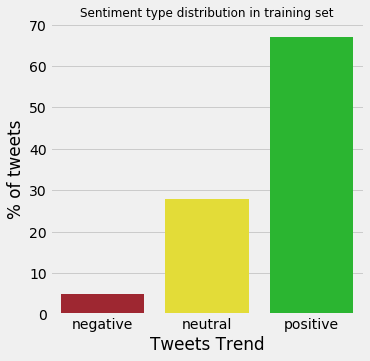

In [23]:
colors = ['#B21321','#FFF61B','#14CC1C']
x_bar=["negative","neutral","positive"]
y_bar=[neg_tweet_count, neu_tweet_count, pos_tweet_count]
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax = sns.barplot(x=x_bar, y=y_bar,palette=colors);
ax.set(ylabel='% of tweets', xlabel='Tweets Trend')
title = 'Sentiment type distribution in training set'
plt.title(title,fontsize = 12)
plt.show()

In [24]:
from collections import Counter
import nltk
import string
nltk.download('stopwords')
import unicodedata


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sunilayyappan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Encode with closest thing to character
def encodeText(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii','ignore')
    return line

top_N = 100
stopwords = nltk.corpus.stopwords.words('english')
stopwords = stopwords + ['rt']
# RegEx for stopwords
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
# replace '|'-->' ' and drop all stopwords
words = (data_tweet.tweet
           .str.lower()
           .replace([r'\|', RE_stopwords], [' ', ''], regex=True)
           .str.cat(sep=' ')
           .split()
)

# generate DF out of Counter
words_data = pd.DataFrame(Counter(words).most_common(300),
                    columns=['Word', 'Frequency']).set_index('Word')

pd.set_option('display.max_rows', top_N)
words_data = words_data.reset_index()
words_data['Word Encoded'] = words_data['Word'].apply(encodeText)
words_data.drop('Word', axis=1).to_csv('word-frequencies.csv')
words_data.head(20)
#pd.reset_option('display.max_rows')

# plot
# rslt.plot.bar(rot=0, figsize=(16,10), width=0.8)

,Word,Frequency,Word Encoded
0,#ipl,7580,b'#ipl'
1,:,5837,b':'
2,#ipl2018,3387,b'#ipl2018'
3,favorite,2916,b'favorite'
4,retweet,2849,b'retweet'
5,-,2540,b'-'
6,?,2407,b'?'
7,#vivoipl,2143,b'#vivoipl'
8,@iplcricket:,2090,b'@iplcricket:'
9,#ipl11,1577,b'#ipl11'


In [26]:
# Deleting stopwords and punctuation is key for proper bigram creation
# Deleting stopwords and punctuation is key for proper bigram creation

all_words3 = ', '.join(data_tweet.tweet)
def bigram(text):
    count = 0
    text_bigram = ''
    for letter in text:
        if letter != ' ':
            text_bigram += letter
        else:
            count += 1
            if count % 2 == 0:
                text_bigram += 'x'
            else:
                text_bigram += letter
    return text_bigram

stopwords1 = ['https', 'RT', 'http', '.co','SSCricket']
for stopword in stopwords1:
    all_words3 = all_words3.replace(stopword,'')

words_bigram = bigram(all_words3)

responsibilities_bigram = bigram(all_words3)

Single Cloud:


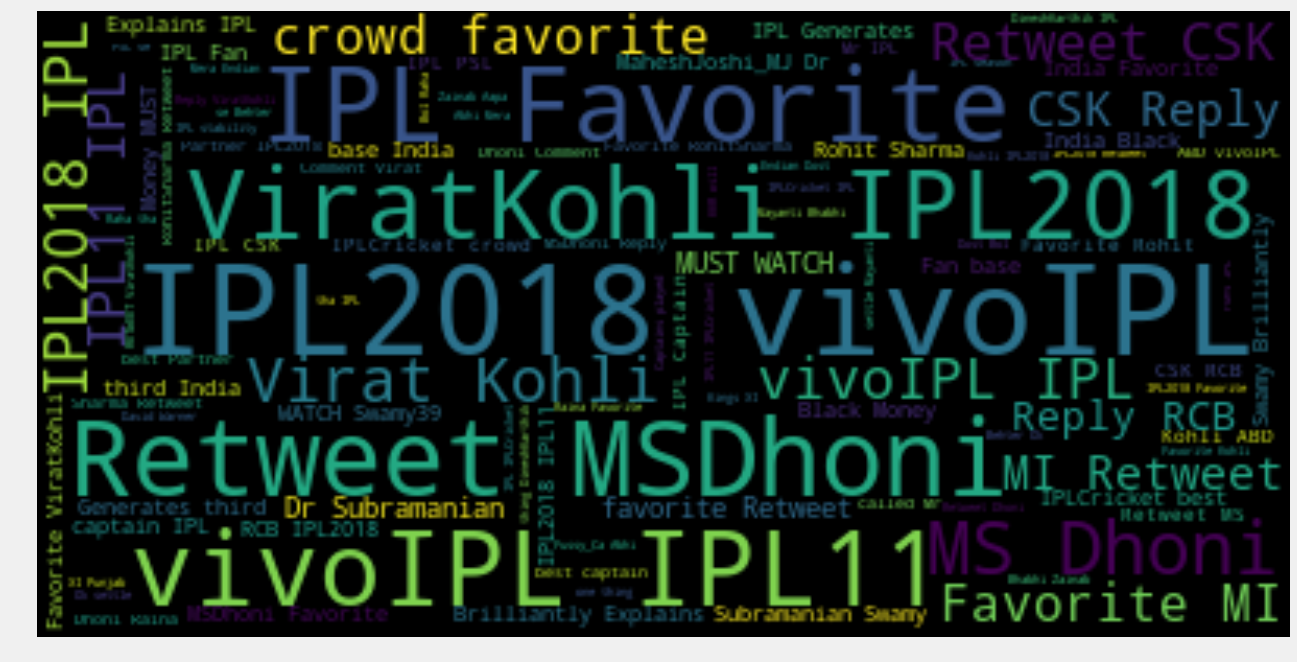

Bigrams:


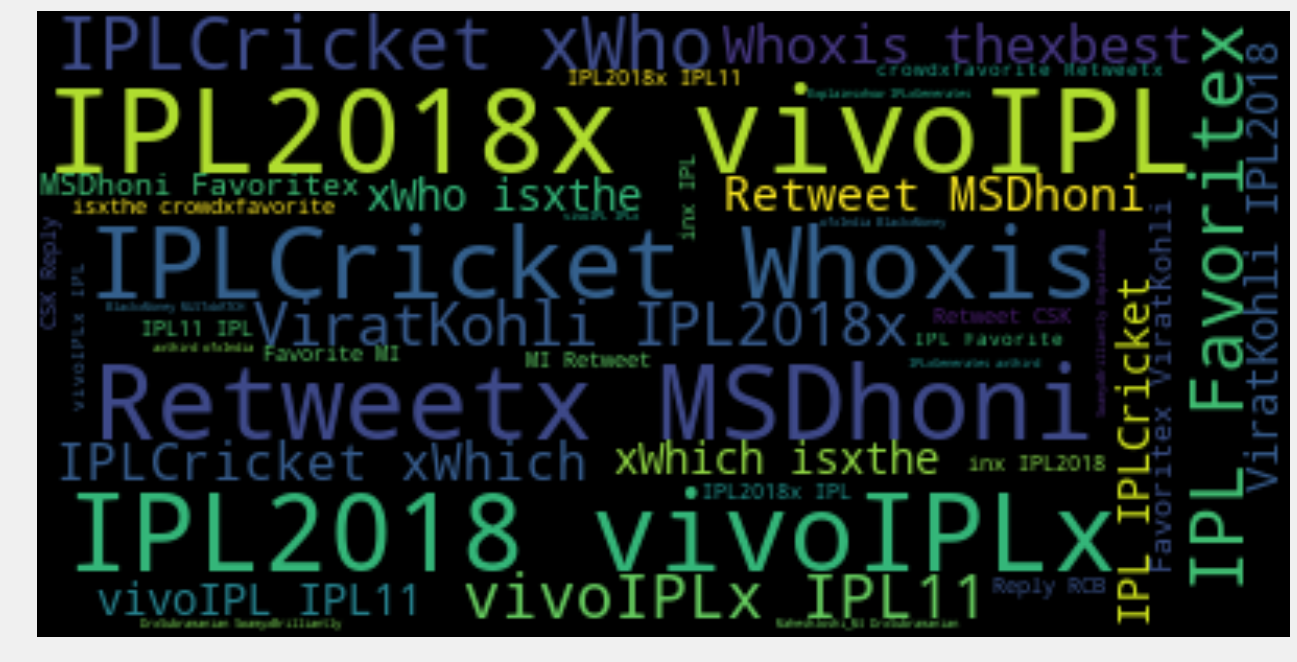

In [27]:
# Single Cloud
wordcloud = WordCloud().generate(all_words3)
print('Single Cloud:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

# Bigram Cloud
wordcloud_bigrams = WordCloud().generate(responsibilities_bigram)
print('Bigrams:')
plt.figure(figsize=(20,20))
plt.imshow(wordcloud_bigrams, interpolation='bilinear')
plt.axis("off")
plt.show();

In [28]:
import os
import pandas as pd
import numpy as np
from IPython.display import display

from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

## Load Labeled Training Data 

For Bag-of-words approach, we're going to use labeled training data for supervised learning. 

In [29]:
df_train = pd.read_excel('data/ipltweets.xls', header=0, delimiter="\t", quoting=3)

<div class="span25 alert alert-warning">
Here, header=0 indicates the first line of the tsv file contains the column names, delimiter="\t" means the file uses tap as delimiter, and quoting=3 tells Python to ignore double quotes.

Take a look at the training data.
</div>

In [30]:
print('Dimension of Labeled Training Data: {}.'.format(df_train.shape))
print('There are {0} samples and {1} variables in the training data.'.format(df_train.shape[0], df_train.shape[1]))

Dimension of Labeled Training Data: (435, 8).
There are 435 samples and 8 variables in the training data.


In [31]:
display(df_train.head())

,id,created,tweet,source,fav_count,retweet,len,SA
0,965356476700094464,2018-02-18 22:44:54,RT @Beingsukhveer: Most Fan Based Team in #ICC...,Twitter Lite,0,5,140,1
1,965354854284701696,2018-02-18 22:38:27,RT @cricketaakash: #KXIP and #MI must be worri...,Twitter Lite,0,49,123,1
2,965354139499749376,2018-02-18 22:35:36,RT @Aparajithan29: #chrisgayle situation in to...,Twitter for Android,0,1,97,0
3,965341599533236224,2018-02-18 21:45:47,RT @cricketaakash: #KXIP and #MI must be worri...,Twitter for Android,0,49,123,1
4,965335164787113984,2018-02-18 21:20:13,"RT @cricketaakash: As you'd asked, here's the ...",Twitter Lite,0,161,137,0


<div class="span25 alert alert-info">
Take a closer look at a tweet entry.
</div>

<div class="span25 alert alert-info">
Even though the review text is not in HTML, let's use the package BeautifulSoup. This is a tw
</div>

In [32]:
df_train['review_bs'] = df_train['tweet'].apply(lambda x: BeautifulSoup(x, 'html.parser'))

In [33]:
df_train.review_bs[0].get_text()

'RT @Beingsukhveer: Most Fan Based Team in #ICC \n\nFavorite :- Pakistan\n\nRetweet :- India \n\nreply :-  Others\n\n#IPL #IPL2018 #Raina #Bhuvi #Dh…'

### Data Cleaning and Text Preprocessing


<div class="span25 alert alert-info">
Use re package to remove digits and punctuations. To build a simplified Bag-of-words model, we remove both digits and punctuations.
</div>

In [34]:
df_train['review_letters_only'] = df_train['review_bs'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x.get_text()))

<div class="span25 alert alert-info">
The reviews are now strings of letters only.
</div>

In [35]:
df_train['review_letters_only'][0]

'RT  Beingsukhveer  Most Fan Based Team in  ICC   Favorite    Pakistan  Retweet    India   reply     Others   IPL  IPL      Raina  Bhuvi  Dh '

<div class="span25 alert alert-info">
Convert words into lower case and tonkenize, i.e. split the text into individual words.
</div>

In [36]:
df_train['review_words'] = df_train['review_letters_only'].apply(lambda x: x.lower().split())

<div class="span25 alert alert-info">
The reviews are now list of word strings.
</div>

In [37]:
df_train['review_words'][0]

['rt',
 'beingsukhveer',
 'most',
 'fan',
 'based',
 'team',
 'in',
 'icc',
 'favorite',
 'pakistan',
 'retweet',
 'india',
 'reply',
 'others',
 'ipl',
 'ipl',
 'raina',
 'bhuvi',
 'dh']

<div class="span25 alert alert-info">
Remove stop words with ntlk.
</div>

In [38]:
set_of_stopwords = set(stopwords.words("english"))
df_train['review_meaningful_words'] = df_train['review_words'].apply(lambda x: [w for w in x if not w in set_of_stopwords])

In [39]:
num_removed = len(df_train['review_words'][0]) - len(df_train['review_meaningful_words'][0])
print('For the first review entry, the number of stop words removed is {0}.'.format(num_removed))


For the first review entry, the number of stop words removed is 2.


<div class="span25 alert alert-info">
As the final step, we join the list of words into a single string.
</div>

In [40]:
# train['review_cleaned'] = train['review_stemmed'].apply(lambda x: ' '.join(x)) # uncomment if using stemming
df_train['review_cleaned'] = df_train['review_meaningful_words'].apply(lambda x: ' '.join(x)) # comment if using stemming

<div class="span25 alert alert-info">
Add review_cleaned as a new column to the training data.
</div>



In [41]:
df_train.drop(['tweet', 'review_bs', 'review_letters_only', 'review_words', 'review_meaningful_words'], 
           axis=1, inplace=True)
display(df_train.head())

,id,created,source,fav_count,retweet,len,SA,review_cleaned
0,965356476700094464,2018-02-18 22:44:54,Twitter Lite,0,5,140,1,rt beingsukhveer fan based team icc favorite p...
1,965354854284701696,2018-02-18 22:38:27,Twitter Lite,0,49,123,1,rt cricketaakash kxip mi must worried miller d...
2,965354139499749376,2018-02-18 22:35:36,Twitter for Android,0,1,97,0,rt aparajithan chrisgayle situation today ipl ...
3,965341599533236224,2018-02-18 21:45:47,Twitter for Android,0,49,123,1,rt cricketaakash kxip mi must worried miller d...
4,965335164787113984,2018-02-18 21:20:13,Twitter Lite,0,161,137,0,rt cricketaakash asked playing xi csk aakashva...


In [42]:
print(df_train['review_cleaned'][0])

rt beingsukhveer fan based team icc favorite pakistan retweet india reply others ipl ipl raina bhuvi dh


<div class="span25 alert alert-info">
Now the training data is ready for using Bag of Words.
</div>


## Creating Features from a Bag of Words (Using scikit-learn)¶


In [44]:
pd.set_option('max_colwidth', 800)


In [46]:
df_train[df_train.SA == 0][0:10]

,id,created,source,fav_count,retweet,len,SA,review_cleaned
2,965354139499749376,2018-02-18 22:35:36,Twitter for Android,0,1,97,0,rt aparajithan chrisgayle situation today ipl auction ipl https co h aofnnlvu
4,965335164787113984,2018-02-18 21:20:13,Twitter Lite,0,161,137,0,rt cricketaakash asked playing xi csk aakashvani ipl agree picks https co p br cogrx
5,965332947044794368,2018-02-18 21:11:24,Twitter Web Client,0,276,140,0,rt socceriraq heartbreaking story ipl today naft maysan goalkeeper alaa ahmed played fantastic game al shorta w
8,965328926074724352,2018-02-18 20:55:25,Twitter for Android,0,3,140,0,rt iplt official highest totals ipl history rcb vs pwi rcb vs gl csk vs rr csk v
9,965323599497383936,2018-02-18 20:34:15,Twitter for Android,0,1,140,0,rt faruksk highest totals ipl history rcb vs pwi rcb vs gl csk vs rr csk v
12,965319338524905472,2018-02-18 20:17:19,Twitter for Android,0,1,106,0,rt innobystander ipl brought conjunction duncan norvelle https co edtlqkymga
23,965305867053625344,2018-02-18 19:23:47,Twitter for Android,0,15,140,0,rt iplcricket highest totals ipl history rcb vs pwi rcb vs gl csk vs rr csk vs kxi
26,965301093533134848,2018-02-18 19:04:49,Twitter Lite,2,0,60,0,psl class ipl https co javnj fe
27,965301040420704256,2018-02-18 19:04:37,Twitter for Android,0,15,140,0,rt iplcricket highest totals ipl history rcb vs pwi rcb vs gl csk vs rr csk vs kxi
28,965298555043774464,2018-02-18 18:54:44,Twitter for Android,0,3,140,0,rt iplt official highest totals ipl history rcb vs pwi rcb vs gl csk vs rr csk v


In [48]:
df_train.shape

(435, 8)

- Create a dictionary of features
- Create a dictionary of features and then count the feature values for each sentence
- All words available in all sentences become part of the dictionary
- We will limit number of features to be used in this tutorial to 5000

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
count_vectorizer = CountVectorizer( max_features = 5000 )

In [51]:
feature_vector = count_vectorizer.fit( df_train.review_cleaned )
df_train_features = count_vectorizer.transform( df_train.review_cleaned )

In [52]:
features = feature_vector.get_feature_names()

#### What are the features extracted?

In [53]:
features[0:10]

['aakashvani',
 'aaki',
 'abdevilliers',
 'absolute',
 'according',
 'acne',
 'acnetreatments',
 'actions',
 'aczq',
 'afghanistan']

#### Count occurance of these features across all sentences

In [54]:
features_counts = np.sum( df_train_features.toarray(), axis = 0 )

In [55]:
feature_counts = pd.DataFrame( dict( features = features,
                                  counts = features_counts ) )

In [56]:
feature_counts.head(5)

,counts,features
0,1,aakashvani
1,1,aaki
2,2,abdevilliers
3,1,absolute
4,1,according


In [60]:
feature_counts.sort_values( "counts", ascending = False )[1:20]

,counts,features
782,317,rt
393,156,https
143,152,co
1007,134,vs
745,133,rcb
179,126,csk
562,101,mi
911,73,team
435,69,iplcricket
762,67,retweet


The features list contains quite a few stop words, which may have no meaning. Let's remove the words and create a new dictionary

In [61]:
count_vectorizer = CountVectorizer( stop_words = "english",
                                 max_features = 5000 )
feature_vector = count_vectorizer.fit( df_train.review_cleaned )
train_ds_features = count_vectorizer.transform( df_train.review_cleaned )

In [62]:
features = feature_vector.get_feature_names()
features_counts = np.sum( train_ds_features.toarray(), axis = 0 )
feature_counts = pd.DataFrame( dict( features = features,
                                  counts = features_counts ) )
feature_counts.sort_values( "counts", ascending = False )[0:20]

,counts,features
410,611,ipl
741,317,rt
370,156,https
952,134,vs
704,133,rcb
170,126,csk
533,101,mi
863,73,team
412,69,iplcricket
950,67,vivoipl


### Build a naive-bayes classifier

In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split

In [64]:
clf = GaussianNB()

In [65]:
train_X, test_X, train_y, test_y = train_test_split( train_ds_features,
                                                  df_train.SA,
                                                  test_size = 0.3,
                                                  random_state = 42 )

In [66]:
clf.fit( train_X.toarray(), train_y )


GaussianNB(priors=None)

#### Test the model

In [67]:
test_ds_predicted = clf.predict( test_X.toarray() )


#### Evaluate the model

In [68]:
from sklearn import metrics
cm = metrics.confusion_matrix( test_y, test_ds_predicted )
cm

array([[ 8,  2,  2],
       [ 4, 42,  3],
       [ 2,  5, 63]])

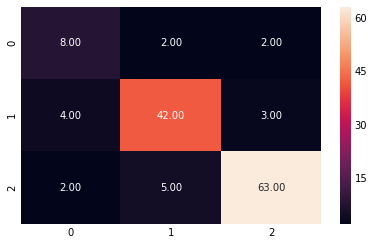

In [71]:
import seaborn as sn
%matplotlib inline
sn.heatmap(cm, annot=True,  fmt='.2f' );

In [74]:
print("classification report: \n", classification_report(test_y, test_ds_predicted))

classification report: 
              precision    recall  f1-score   support

         -1       0.57      0.67      0.62        12
          0       0.86      0.86      0.86        49
          1       0.93      0.90      0.91        70

avg / total       0.87      0.86      0.86       131



In [72]:
score = metrics.accuracy_score( test_y, test_ds_predicted )

In [73]:
score


0.8625954198473282

## Conclusion

<div class="span25 alert alert-info">
The #ipl tag had a good number of tweets and we were able to demonstrate pretty much most of what sentiment analysis could do. Now during the season premiere on April 7th, I will be trying to rerun this on a daily basis to get the general mood of audience. It was fascinating to see the use of this technology during IPL auction. 
</div>